# Пример с распознаванием цифр

In [1]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

Загружаем данные

In [2]:
digits = datasets.load_digits()

Пример первой цифры

In [3]:
digits['data'][0].reshape(8, 8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [4]:
digits['target'][:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Нарисуем пример цифры

In [5]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

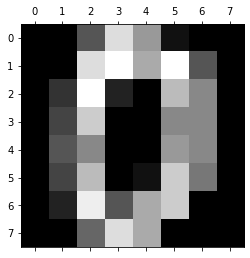

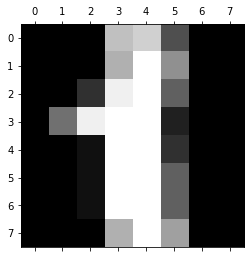

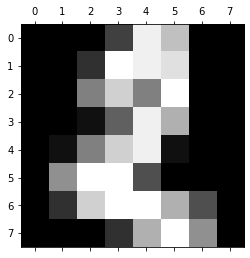

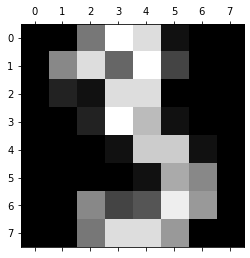

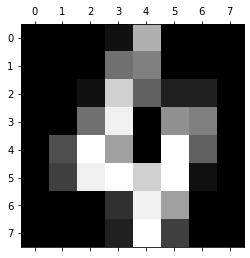

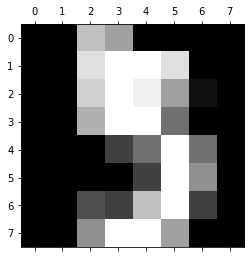

In [6]:
plt.gray()
for i in range(0, 6):
    plt.matshow(digits.images[i])
    
plt.show() 

Признаки и целевая переменная

In [7]:
X_digits = digits.data
Y_digits = digits.target

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import operator
from tqdm import tqdm

# Поиск максимального score

Сделаем свой grid search. Будем перебирать по: 1) размеру тестовой выборки, 2) количеству соседей, 3) параметру p для метрики minkowski, 4) весу расстояния.

Результаты занесем в массив, отсортируем и покажем лучшие параметры.

In [9]:
res = []

for t in tqdm([0.1, 0.2, 0.3]):
    X_train, X_test, Y_train, Y_test = train_test_split(X_digits, Y_digits, test_size=t, random_state=42)
    for n in range(1, 11):
        for p in range(1, 16):
            for w in ['distance', 'uniform']:
                knn = KNeighborsRegressor( n_neighbors = n, weights = w, metric='minkowski', p=p )
                model = knn.fit( X_train, Y_train )
                res.append([t, n, w, 'minkowski', p, knn.score(X_test, Y_test)])
    
best = sorted(res, key=operator.itemgetter(5), reverse=True)[0]

X_train, X_test, Y_train, Y_test = train_test_split(X_digits, Y_digits, test_size=best[0], random_state=42)

print('score: {5}, test size: {0}, metric: {3}, p: {4}, neighbors: {1}, weights: {2}'.format(*best))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:56<00:00, 178.79s/it]

score: 0.9924031279364219, test size: 0.1, metric: minkowski, p: 11, neighbors: 5, weights: uniform


Создадим модель с найденными наилучшими параметрами и проверим ее score:

In [10]:
knn = KNeighborsRegressor( n_neighbors=5, p=11, weights='uniform', metric='minkowski' )
model = knn.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.9924031279364219

Определим картинки, где наша модель не смогла правильно установить цифру. Поместим в массивы: индексы картинки, правильную цифру и цифру, которая была предсказана:

In [11]:
predict = model.predict(X_test)
true_dig = []
predict_dig = []
idx = []
for x in range(len(X_test)):
    d = model.predict([X_test[x]])[0]
    if (Y_test[x] != d):
        true_dig.append(Y_test[x])
        predict_dig.append(d)
        idx.append(x)

Вот, где наша модель не сработала:

In [12]:
print(tuple(zip(true_dig, predict_dig)))

((1, 1.2), (9, 8.2), (9, 6.6), (6, 5.8), (1, 1.6), (9, 7.8), (8, 8.4), (7, 7.4), (3, 3.6), (9, 8.2), (3, 4.0))


Тут все понятно. Единица легко путается с семеркой, шестерка, восьмерка, девятка -- путаются между собой при неаккуратном написании.

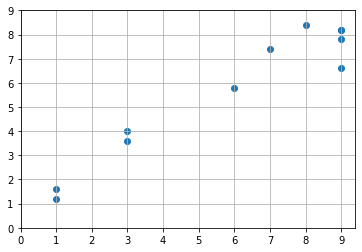

In [13]:
plt.scatter(true_dig, predict_dig)
plt.xticks([*range(0,10)])
plt.yticks([*range(0,10)])
plt.grid()

Интереснее будет глянуть как выглядели рисунки, которые мы не смогли распознать:

<Figure size 432x288 with 0 Axes>

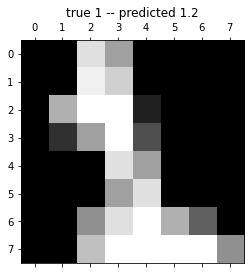

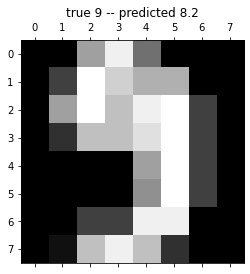

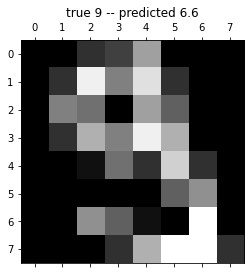

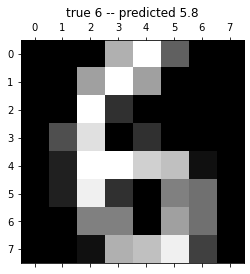

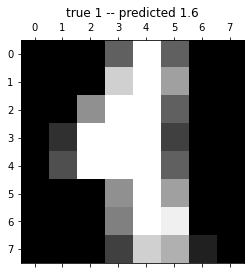

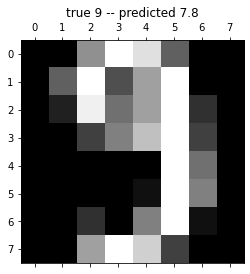

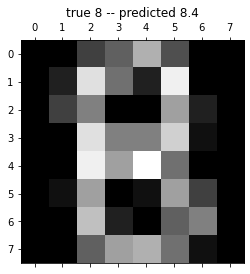

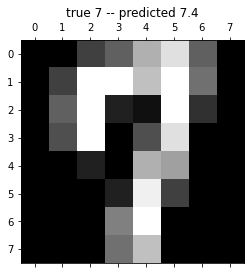

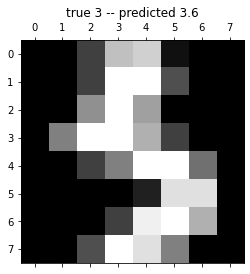

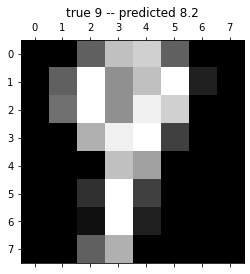

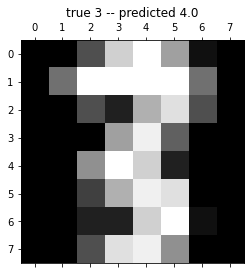

In [14]:
plt.gray()
for i in range(len(idx)):
    plt.matshow(X_test[idx[i]].reshape(8, 8))
    plt.title('true {0} -- predicted {1}'.format(true_dig[i], predict_dig[i]))
    
plt.show() 

Теперь тоже самое попробуем сделать с помощью GridSearch. Сразу скажу 99% достичь не удалось. Только 98%. Хотелось бы понять почему.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [16]:
grid = {
    'n_neighbors': [*range(1,11)],
    'weights': ['uniform', 'distance'],
    'p': [*range(1,16)]    
}
gridsearch = GridSearchCV(KNeighborsRegressor(metric='minkowski'), 
                          grid, cv=5, n_jobs=-1, verbose=1,
                          scoring='r2')
gridsearch.fit(X_train, Y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  4.7min finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=1)

In [17]:
gridsearch.best_params_

{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

Создаем модель с лучшими найденными параметрами и проверяем ее эффективность:

In [18]:
knn = KNeighborsRegressor( metric='minkowski', **gridsearch.best_params_ )
model = knn.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.9817453829010544

Она меньше, чем получилось при ручном поиске. Разные методики скоринга были испробованы.